# Model Interpretation Methods

In this project I will focus on the interpretation of machine learning and deep learning models.

## Packages

I'll first import the necessary packages for this assignment.

- `keras`: I'll use this framework to interact with our deep learning model
- `matplotlib`: standard plotting library
- `pandas`: I'll use this to manipulate data
- `numpy`: standard python library for numerical operations
- `cv2`: library that contains convenience functions for image processing
- `sklearn`: standard machine learning library
- `lifelines`: I'll use their implementation of the c-index
- `shap`: library for interpreting and visualizing machine learning models using shapley values


In [ ]:
import keras
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import sklearn
import lifelines
import shap


from util import *

plt.rcParams['figure.figsize'] = [10, 7]

Using TensorFlow backend.


<a name="1"></a>
## 1 Interpreting Deep Learning Models


In [ ]:
model = load_C3M3_model()

Got loss weights
Loaded DenseNet
Added layers
Compiled Model
Loaded Weights


Let's load in an X-ray image to develop on. The next cell to load and show the image.

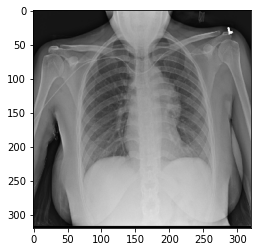

In [ ]:
IMAGE_DIR = 'nih_new/images-small/'
df = pd.read_csv("nih_new/train-small.csv")
im_path = IMAGE_DIR + '00025288_001.png' 
x = load_image(im_path, df, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()

Next, let's get our predictions. Before I plug the image into our model, I have to normalize it. The next cell shows the mean and standard deviation of the images in the training set. 

In [ ]:
mean, std = get_mean_std_per_batch(df)

Now it's time to normalize and run the image through the model to get predictions.

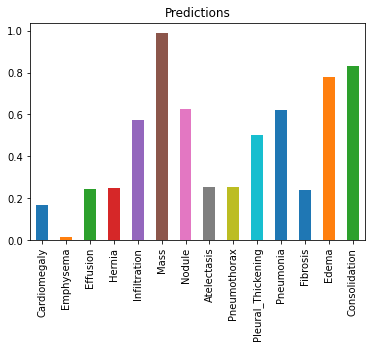

In [ ]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

processed_image = load_image_normalize(im_path, mean, std)
preds = model.predict(processed_image)
pred_df = pd.DataFrame(preds, columns = labels)
pred_df.loc[0, :].plot.bar()
plt.title("Predictions")
plt.show()

The model predicts Mass (abnormal spot or area in the lungs that are more than 3 centimeters) with high probability. Indeed, this patient was diagnosed with mass. However, I don't know where the model is looking when it's making its own diagnosis. To gain more insight into what the model is looking at, I can use GradCAMs.

<a name="1-1"></a>
### 1.1 GradCAM

GradCAM is a technique to visualize the impact of each region of an image on a specific output for a Convolutional Neural Network model. Through GradCAM, I can generate a heatmap by computing gradients of the specific class scores.

<a name="1-1-1"></a>
#### 1.1.1 Getting Intermediate Layers

Perhaps the most complicated part of computing GradCAM is accessing intermediate activations in our deep learning model and computing gradients with respect to the class output. Now I'll go over one pattern to accomplish this, which I can use when implementing GradCAM.

In order to understand how to access intermediate layers in a computation, first let's see the layers that the model is composed of. This can be done by calling Keras convenience function `model.summary()`.

In [ ]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

There are a lot of layers, but typically I'll only be extracting one of the last few. Remember that the last few layers usually have more abstract information. To access a layer, I can use `model.get_layer(layer).output`, which takes in the name of the layer in question. Let's try getting the `conv5_block16_concat` layer, the raw output of the last convolutional layer.

In [ ]:
spatial_maps =  model.get_layer('conv5_block16_concat').output
print(spatial_maps)

Tensor("conv5_block16_concat/concat:0", shape=(?, ?, ?, 1024), dtype=float32)


Now, this tensor is just a placeholder, it doesn't contain the actual activations for a particular image. To get this I will use [Keras.backend.function](https://www.tensorflow.org/api_docs/python/tf/keras/backend/function) to return intermediate computations while the model is processing a particular input. This method takes in an input and output placeholders and returns a function. This function will compute the intermediate output (until it reaches the given placeholder) evaluated given the input.

In [ ]:
get_spatial_maps = K.function([model.input], [spatial_maps])
print(get_spatial_maps)

In [ ]:
# get an image
x = load_image_normalize(im_path, mean, std)
print(f"x is of type {type(x)}")
print(f"x is of shape {x.shape}")

x is of type <class 'numpy.ndarray'>
x is of shape (1, 320, 320, 3)


In [ ]:
# get the spatial maps layer activations (a list of numpy arrays)
spatial_maps_x_l = get_spatial_maps([x])

print(f"spatial_maps_x_l is of type {type(spatial_maps_x_l)}")
print(f"spatial_maps_x_l is has length {len(spatial_maps_x_l)}")

spatial_maps_x_l is of type <class 'list'>
spatial_maps_x_l is has length 1


In [ ]:
# get the 0th item in the list
spatial_maps_x = spatial_maps_x_l[0]
print(f"spatial_maps_x is of type {type(spatial_maps_x)}")
print(f"spatial_maps_x is of shape {spatial_maps_x.shape}")

spatial_maps_x is of type <class 'numpy.ndarray'>
spatial_maps_x is of shape (1, 10, 10, 1024)


Notice that the shape is (1, 10, 10, 1024).  The 0th dimension of size 1 is the batch dimension.  Remove the batch dimension for later calculations by taking the 0th index of spatial_maps_x.

In [ ]:
# Get rid of the batch dimension
spatial_maps_x = spatial_maps_x[0] # equivalent to spatial_maps_x[0,:]
print(f"spatial_maps_x without the batch dimension has shape {spatial_maps_x.shape}")
print("Output some of the content:")
print(spatial_maps_x[0])

spatial_maps_x without the batch dimension has shape (10, 10, 1024)
Output some of the content:
[[-0.53140813  0.1710349  -0.5496394  ...  0.09337543 -0.04922793
   0.12406566]
 [-0.86855346 -0.25384095 -0.8086766  ...  0.18068464 -0.08305137
   0.22288626]
 [-0.5227741  -0.06553538 -0.4945901  ...  0.2559961  -0.10659091
   0.2852915 ]
 ...
 [-0.45182693 -0.24394709 -0.7833127  ...  0.15765719 -0.07490491
   0.21524286]
 [-0.542987   -0.286656   -0.47404775 ...  0.18987669 -0.09477621
   0.27566475]
 [-0.34090397  0.4865079  -0.22056994 ...  0.07397121 -0.0391035
   0.15544441]]


Now I have the activations for that particular image, and I can use it for interpretation. The function that is returned by calling `K.function([model.input], [spatial_maps])` (saved here in the variable `get_spatial_maps`) is sometimes referred to as a "hook".

<a name="1-1-2"></a>
#### 1.1.2 Getting Gradients

In [ ]:
# get the output of the model
output_with_batch_dim = model.output
print(f"Model output includes batch dimension, has shape {output_with_batch_dim.shape}")

Model output includes batch dimension, has shape (?, 14)


In [ ]:
# Get the output without the batch dimension
output_all_categories = output_with_batch_dim[0]
print(f"The output for all 14 categories of disease has shape {output_all_categories.shape}")

The output for all 14 categories of disease has shape (14,)


The output has 14 categories, one for each disease category, indexed from 0 to 13. Cardiomegaly is the disease category at index 0.

In [ ]:
# Get the first category's output (Cardiomegaly) at index 0
y_category_0 = output_all_categories[0]
print(f"The Cardiomegaly output is at index 0, and has shape {y_category_0.shape}")

The Cardiomegaly output is at index 0, and has shape ()


In [ ]:
# Get gradient of y_category_0 with respect to spatial_maps

gradient_l = K.gradients(y_category_0, spatial_maps)
print(f"gradient_l is of type {type(gradient_l)} and has length {len(gradient_l)}")

# gradient_l is a list of size 1.  Get the gradient at index 0
gradient = gradient_l[0]
print(gradient)

gradient_l is of type <class 'list'> and has length 1
Tensor("gradients/AddN:0", shape=(?, ?, ?, 1024), dtype=float32)


Again, this is just a placeholder. Just like for intermediate layers, I can use `K.function` to compute the value of the gradient for a particular input.  

The K.function() takes in
- a list of inputs: in this case, one input, 'model.input'
- a list of tensors: in this case, one output tensor 'gradient'

It returns a function that calculates the activations of the list of tensors.
- This returned function returns a list of the activations, one for each tensor that was passed into K.function().

In [ ]:
# Create the function that gets the gradient
get_gradient = K.function([model.input], [gradient])
type(get_gradient)

keras.backend.tensorflow_backend.Function

In [ ]:
# get an input x-ray image
x = load_image_normalize(im_path, mean, std)
print(f"X-ray image has shape {x.shape}")

X-ray image has shape (1, 320, 320, 3)


The `get_gradient` function takes in a list of inputs, and returns a list of the gradients, one for each image.

In [ ]:
# use the get_gradient function to get the gradient (pass in the input image inside a list)
grad_x_l = get_gradient([x])
print(f"grad_x_l is of type {type(grad_x_l)} and length {len(grad_x_l)}")

# get the gradient at index 0 of the list.
grad_x_with_batch_dim = grad_x_l[0]
print(f"grad_x_with_batch_dim is type {type(grad_x_with_batch_dim)} and shape {grad_x_with_batch_dim.shape}")

# To remove the batch dimension, take the value at index 0 of the batch dimension
grad_x = grad_x_with_batch_dim[0]
print(f"grad_x is type {type(grad_x)} and shape {grad_x.shape}")

print("Gradient grad_x (show some of its content:")
print(grad_x[0])

grad_x_l is of type <class 'list'> and length 1
grad_x_with_batch_dim is type <class 'numpy.ndarray'> and shape (1, 10, 10, 1024)
grad_x is type <class 'numpy.ndarray'> and shape (10, 10, 1024)
Gradient grad_x (show some of its content:
[[-1.0314199e-09  2.0780584e-09  2.4352136e-07 ...  6.7997826e-05
  -4.5512043e-05  4.7421116e-05]
 [-1.0314199e-09  2.0780584e-09  2.4352136e-07 ...  6.7997826e-05
  -4.5512043e-05  4.7421116e-05]
 [-1.0314199e-09  2.0780584e-09  2.4352136e-07 ...  6.7997826e-05
  -4.5512043e-05  4.7421116e-05]
 ...
 [-1.0314199e-09  2.0780584e-09  2.4352136e-07 ...  6.7997826e-05
  -4.5512043e-05  4.7421116e-05]
 [-1.0314199e-09  2.0780584e-09  2.4352136e-07 ...  6.7997826e-05
  -4.5512043e-05  4.7421116e-05]
 [-1.0314199e-09  2.0780584e-09  2.4352136e-07 ...  6.7997826e-05
  -4.5512043e-05  4.7421116e-05]]


Just like I had a hook into the penultimate layer, I now have a hook into the gradient! This allows to easily compute pretty much anything relevant to the model output. 

I can also combine the two to have one function call which gives the both, the gradient and the last layer (this might come in handy when implementing GradCAM in the next section).

In [ ]:
# Use K.function to generate a single function
# Notice that a list of two tensors, is passed in as the second argument of K.function()
get_spatial_maps_and_gradient = K.function([model.input], [spatial_maps, gradient])
print(type(get_spatial_maps_and_gradient))

<class 'keras.backend.tensorflow_backend.Function'>


In [ ]:
tensor_eval_l = get_spatial_maps_and_gradient([x])
print(f"tensor_eval_l is type {type(tensor_eval_l)} and length {len(tensor_eval_l)}")

tensor_eval_l is type <class 'list'> and length 2


In [ ]:
spatial_maps_x_with_batch_dim, grad_x_with_batch_dim = tensor_eval_l
print(f"spatial_maps_x_with_batch_dim has shape {spatial_maps_x_with_batch_dim.shape}")
print(f"grad_x_with_batch_dim has shape {grad_x_with_batch_dim.shape}")

spatial_maps_x_with_batch_dim has shape (1, 10, 10, 1024)
grad_x_with_batch_dim has shape (1, 10, 10, 1024)


In [ ]:
spatial_maps_x_with_batch_dim, grad_x_with_batch_dim = get_spatial_maps_and_gradient([x])
print(f"spatial_maps_x_with_batch_dim has shape {spatial_maps_x_with_batch_dim.shape}")
print(f"grad_x_with_batch_dim has shape {grad_x_with_batch_dim.shape}")

spatial_maps_x_with_batch_dim has shape (1, 10, 10, 1024)
grad_x_with_batch_dim has shape (1, 10, 10, 1024)


In [ ]:
spatial_maps_x = spatial_maps_x_with_batch_dim[0]
grad_x = grad_x_with_batch_dim[0]
print(f"spatial_maps_x shape {spatial_maps_x.shape}")
print(f"grad_x shape {grad_x.shape}")

print("\nSpatial maps (print some content):")
print(spatial_maps_x[0])
print("\nGradient (print some content:")
print(grad_x[0])

spatial_maps_x shape (10, 10, 1024)
grad_x shape (10, 10, 1024)

Spatial maps (print some content):
[[-0.53140813  0.1710349  -0.5496394  ...  0.09337543 -0.04922793
   0.12406566]
 [-0.86855346 -0.25384095 -0.8086766  ...  0.18068464 -0.08305137
   0.22288626]
 [-0.5227741  -0.06553538 -0.4945901  ...  0.2559961  -0.10659091
   0.2852915 ]
 ...
 [-0.45182693 -0.24394709 -0.7833127  ...  0.15765719 -0.07490491
   0.21524286]
 [-0.542987   -0.286656   -0.47404775 ...  0.18987669 -0.09477621
   0.27566475]
 [-0.34090397  0.4865079  -0.22056994 ...  0.07397121 -0.0391035
   0.15544441]]

Gradient (print some content:
[[-1.0314199e-09  2.0780584e-09  2.4352136e-07 ...  6.7997826e-05
  -4.5512043e-05  4.7421116e-05]
 [-1.0314199e-09  2.0780584e-09  2.4352136e-07 ...  6.7997826e-05
  -4.5512043e-05  4.7421116e-05]
 [-1.0314199e-09  2.0780584e-09  2.4352136e-07 ...  6.7997826e-05
  -4.5512043e-05  4.7421116e-05]
 ...
 [-1.0314199e-09  2.0780584e-09  2.4352136e-07 ...  6.7997826e-05
  -4.55120

<a name="1-1-3"></a>
#### 1.1.3 Implementing GradCAM

In [ ]:
def grad_cam(input_model, image, category_index, layer_name):
    """
    GradCAM method for visualizing input saliency.
    
    Args:
        input_model (Keras.model): model to compute cam for
        image (tensor): input to model, shape (1, H, W, 3)
        cls (int): class to compute cam with respect to
        layer_name (str): relevant layer in model
        H (int): input height
        W (int): input width
    Return:
        cam ()
    """
    cam = None

    output_with_batch_dim = input_model.output
    
    output_all_categories = output_with_batch_dim[0]
    
    y_c = output_all_categories[category_index]
    
    spatial_map_layer = input_model.get_layer(layer_name).output

    grads_l = K.gradients(y_c,spatial_map_layer)
    
    grads = grads_l[0]
        
    spatial_map_and_gradient_function = K.function([input_model.input],[spatial_map_layer, grads])

    spatial_map_all_dims, grads_val_all_dims = spatial_map_and_gradient_function([image])

    spatial_map_val = spatial_map_all_dims[0]
    
    grads_val = grads_val_all_dims[0]
    
    weights = np.mean(grads_val,axis=(0,1))
    
    cam = np.dot(spatial_map_val, weights)

    H, W = image.shape[1], image.shape[2]
    cam = np.maximum(cam, 0) 
    cam = cv2.resize(cam, (W, H), cv2.INTER_NEAREST)
    cam = cam / cam.max()

    return cam

Below I generate the CAM for the image and compute the error (pixel-wise mean squared difference) from the expected values according to our reference. 

In [ ]:
im = load_image_normalize(im_path, mean, std)
cam = grad_cam(model, im, 5, 'conv5_block16_concat') # Mass is class 5

# Loads reference CAM to compare our implementation with.
reference = np.load("reference_cam.npy")
error = np.mean((cam-reference)**2)

print(f"Error from reference: {error:.4f}, should be less than 0.05")

Error from reference: 0.0310, should be less than 0.05


The next cell visualize the CAM and the original image. 

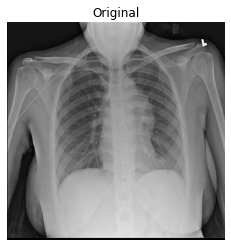

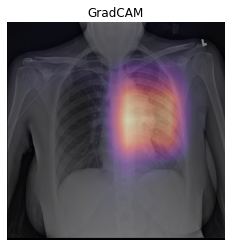

In [ ]:
plt.imshow(load_image(im_path, df, preprocess=False), cmap='gray')
plt.title("Original")
plt.axis('off')

plt.show()

plt.imshow(load_image(im_path, df, preprocess=False), cmap='gray')
plt.imshow(cam, cmap='magma', alpha=0.5)
plt.title("GradCAM")
plt.axis('off')
plt.show()

<a name="1-1-4"></a>
#### 1.1.4 Using GradCAM to Visualize Multiple Labels

In [ ]:
def compute_gradcam(model, img, mean, std, data_dir, df, 
                    labels, selected_labels, layer_name='conv5_block16_concat'):
    """
    Compute GradCAM for many specified labels for an image. 
    This method will use the `grad_cam` function.
    
    Args:
        model (Keras.model): Model to compute GradCAM for
        img (string): Image name I want to compute GradCAM for.
        mean (float): Mean to normalize to image.
        std (float): Standard deviation to normalize the image.
        data_dir (str): Path of the directory to load the images from.
        df(pd.Dataframe): Dataframe with the image features.
        labels ([str]): All output labels for the model.
        selected_labels ([str]): All output labels I want to compute the GradCAM for.
        layer_name: Intermediate layer from the model I want to compute the GradCAM for.
    """
    img_path = data_dir + img
    preprocessed_input = load_image_normalize(img_path, mean, std)
    predictions = model.predict(preprocessed_input)
    print("Ground Truth: ", ", ".join(np.take(labels, np.nonzero(df[df["Image"] == img][labels].values[0]))[0]))

    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img_path, df, preprocess=False), cmap='gray')
    
    j = 1
    
    for i in range(len(labels)): # complete this line
        if labels[i] in selected_labels: # complete this line
            
            gradcam = grad_cam(model,preprocessed_input,i,layer_name)
            
            print("Generating gradcam for class %s (p=%2.2f)" % (labels[i], round(predictions[0][i], 3)))
            plt.subplot(151 + j)
            plt.title(labels[i] + ": " + str(round(predictions[0][i], 3)))
            plt.axis('off')
            plt.imshow(load_image(img_path, df, preprocess=False), cmap='gray')
            plt.imshow(gradcam, cmap='magma', alpha=min(0.5, predictions[0][i]))
            j +=1

The next cell shows the ground truth diagnosis for a given case and show the original x-ray as well as GradCAMs for Cardiomegaly, Mass, and Edema.

Ground Truth:  Cardiomegaly
Generating gradcam for class Cardiomegaly (p=0.96)
Generating gradcam for class Mass (p=0.25)
Generating gradcam for class Edema (p=0.08)


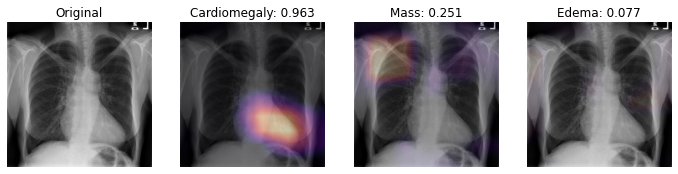

In [ ]:
df = pd.read_csv("nih_new/train-small.csv")

image_filename = '00016650_000.png'
labels_to_show = ['Cardiomegaly', 'Mass', 'Edema']
compute_gradcam(model, image_filename, mean, std, IMAGE_DIR, df, labels, labels_to_show)

Ground Truth:  Mass
Generating gradcam for class Cardiomegaly (p=0.03)
Generating gradcam for class Mass (p=0.99)
Generating gradcam for class Edema (p=0.38)


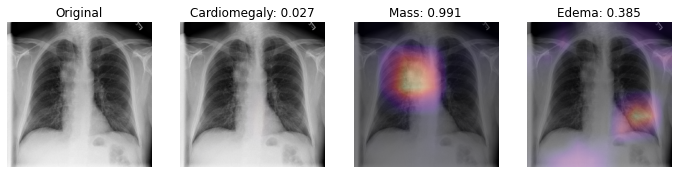

In [ ]:
image_filename = '00005410_000.png'
compute_gradcam(model, image_filename, mean, std, IMAGE_DIR, df, labels, labels_to_show)

In the example above, the model correctly focuses on the mass near the center of the chest cavity. 

Ground Truth:  Edema
Generating gradcam for class Cardiomegaly (p=0.80)
Generating gradcam for class Mass (p=0.32)
Generating gradcam for class Edema (p=1.00)


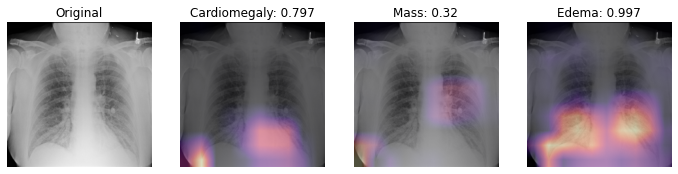

In [ ]:
image_name = '00004090_002.png'
compute_gradcam(model, image_name, mean, std, IMAGE_DIR, df, labels, labels_to_show)

Here the model correctly picks up the signs of edema near the bottom of the chest cavity. I can also notice that Cardiomegaly has a high score for this image, though the ground truth doesn't include it. This visualization might be helpful for error analysis;

This concludes the section on GradCAMs. 

<a name="2"></a>
## 2 Feature Importance in Machine Learning

When developing predictive models and risk measures, it's often helpful to know which features are making the most difference. This is easy to determine in simpler models such as linear models and decision trees. However as I move to more complex models to achieve high performance, I usually sacrifice some interpretability. In this project I'll try to regain some of that interpretability using Shapley values, a technique which has gained popularity in recent years, but which is based on classic results in cooperative game theory. 


In [ ]:
rf = pickle.load(open('nhanes_rf.sav', 'rb')) # Loading the model
test_df = pd.read_csv('nhanest_test.csv')
test_df = test_df.drop(test_df.columns[0], axis=1)
X_test = test_df.drop('y', axis=1)
y_test = test_df.loc[:, 'y']
cindex_test = cindex(y_test, rf.predict_proba(X_test)[:, 1])

print("Model C-index on test: {}".format(cindex_test))

Model C-index on test: 0.7776169781865744


The next cell shows the riskiest individuals according to our model. 

In [ ]:
X_test_risky = X_test.copy(deep=True)
X_test_risky.loc[:, 'risk'] = rf.predict_proba(X_test)[:, 1] # Predicting our risk.
X_test_risky = X_test_risky.sort_values(by='risk', ascending=False) # Sorting by risk value.
X_test_risky.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,risk
572,70.0,80.0,312.0,1.0,54.8,7.0,4.4,222.0,52.0,1.57,7.2,1.0,180.0,417.0,12.5,7.5,45.770473,100.0,0.77
190,69.0,100.0,316.0,1.0,77.7,26.0,4.2,197.0,65.0,1.49,7.5,1.0,165.0,298.0,21.8,8.8,22.129018,65.0,0.69
1300,73.0,80.0,999.0,1.0,52.6,35.0,3.9,258.0,61.0,1.66,6.8,1.0,150.0,314.0,19.4,9.4,26.466850,70.0,0.69
634,66.0,100.0,69.0,2.0,42.9,47.0,3.8,233.0,170.0,1.42,8.6,1.0,180.0,411.0,41.4,7.2,22.129498,80.0,0.68
1221,74.0,80.0,67.0,1.0,40.3,24.0,3.7,139.0,28.0,1.91,6.4,2.0,140.0,495.0,5.7,4.1,22.066389,60.0,0.68


<a name="2-1"></a>
### 2.1 Permuation Method for Feature Importance

First I'll try to determine feature importance using the permutation method. In the permutation method, the importance of feature $i$ would be the regular performance of the model minus the performance with the values for feature $i$ permuted in the dataset. This way I can assess how well a model without that feature would do without having to train a new model for each feature. 

<a name="2-1-1"></a>
#### 2.1.1 Implementing Permutation

In [ ]:
def permute_feature(df, feature):
    """
    Given dataset, returns version with the values of
    the given feature randomly permuted. 

    Args:
        df (dataframe): The dataset, shape (num subjects, num features)
        feature (string): Name of feature to permute
    Returns:
        permuted_df (dataframe): Exactly the same as df except the values
                                of the given feature are randomly permuted.
    """
    permuted_df = df.copy(deep=True) 

    permuted_features = np.random.permutation(permuted_df[feature])
    
    # Set the column 'feature' to its permuted values.
    permuted_df[feature] = permuted_features

    return permuted_df

In [ ]:
print("Test Case")

example_df = pd.DataFrame({'col1': [0, 1, 2], 'col2':['A', 'B', 'C']})
print("Original dataframe:")
print(example_df)
print("\n")

print("col1 permuted:")
print(permute_feature(example_df, 'col1'))

print("\n")
print("Compute average values over 1000 runs to get expected values:")
col1_values = np.zeros((3, 1000))
np.random.seed(0) 
for i in range(1000):
    col1_values[:, i] = permute_feature(example_df, 'col1')['col1'].values

print("Average of col1: {}, expected value: [0.976, 1.03, 0.994]".format(np.mean(col1_values, axis=1)))

Test Case
Original dataframe:
   col1 col2
0     0    A
1     1    B
2     2    C


col1 permuted:
   col1 col2
0     1    A
1     2    B
2     0    C


Compute average values over 1000 runs to get expected values:
Average of col1: [0.976 1.03  0.994], expected value: [0.976, 1.03, 0.994]


<a name="2-1-2"></a>
#### 2.1.2 Implementing Importance

In [ ]:
def permutation_importance(X, y, model, metric, num_samples = 100):
    """
    Compute permutation importance for each feature.

    Args:
        X (dataframe): Dataframe for test data, shape (num subject, num features)
        y (np.array): Labels for each row of X, shape (num subjects,)
        model (object): Model to compute importances for, guaranteed to have
                        a 'predict_proba' method to compute probabilistic 
                        predictions given input
        metric (function): Metric to be used for feature importance. Takes in ground
                           truth and predictions as the only two arguments
        num_samples (int): Number of samples to average over when computing change in
                           performance for each feature
    Returns:
        importances (dataframe): Dataframe containing feature importance for each
                                 column of df with shape (1, num_features)
    """

    importances = pd.DataFrame(index = ['importance'], columns = X.columns)
    
    baseline_performance = metric(y, model.predict_proba(X)[:, 1])

    for feature in importances.columns:

        feature_performance_arr = np.zeros(num_samples)
        
        # Loop through each sample
        for i in range(num_samples): 
            
            # permute the column of dataframe X
            perm_X = permute_feature(X,feature)
            
            # calculate the performance with the permuted data
            # Use the same metric function that was used earlier
            feature_performance_arr[i] = metric(y, model.predict_proba(perm_X)[:, 1])

        importances[feature]['importance'] = np.abs(baseline_performance - np.mean(feature_performance_arr))

    return importances

<a name="2-1-3"></a>
#### 2.1.3 Computing our Feature Importance

Next, I will compute importances on my dataset. Since I am computing the permutation importance for all the features, it might take a few minutes to run.

In [ ]:
importances = permutation_importance(X_test, y_test, rf, cindex, num_samples=100)
importances

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
importance,0.147772,0.0113034,0.0111148,0.000449158,0.000805694,0.006285,0.00527172,0.000848118,0.000203789,0.00274019,0.00154867,0.0272337,0.00618949,0.00225922,0.000425288,0.00256128,0.00304884,0.00379624


Let's plot these in a bar chart for easier comparison.

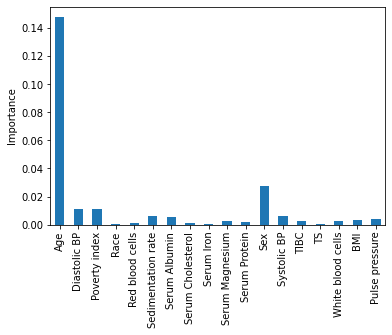

In [ ]:
importances.T.plot.bar()
plt.ylabel("Importance")
l = plt.legend()
l.remove()
plt.show()

The age as by far the best prediction of near term mortality, as one might expect. Next is sex, followed by diastolic blood pressure. Interestingly, the poverty index also has a large impact, despite the fact that it is not directly related to an individual's health. This alludes to the importance of social determinants of health in this model. 

<a name="2-2"></a>
### 2.2 Shapley Values for Random Forests

I'll contrast the permutation method with a more recent technique known as Shapley values (actually, Shapley values date back to the mid 20th century, but have only been applied to machine learning very recently). 

<a name="2-2-1"></a>
#### 2.2.1 Visualizing Feature Importance on Specific Individuals

I can use Shapley values to try and understand the model output on specific individuals. In general Shapley values take exponential time to compute, but luckily there are faster approximations for forests in particular that run in polynomial time.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


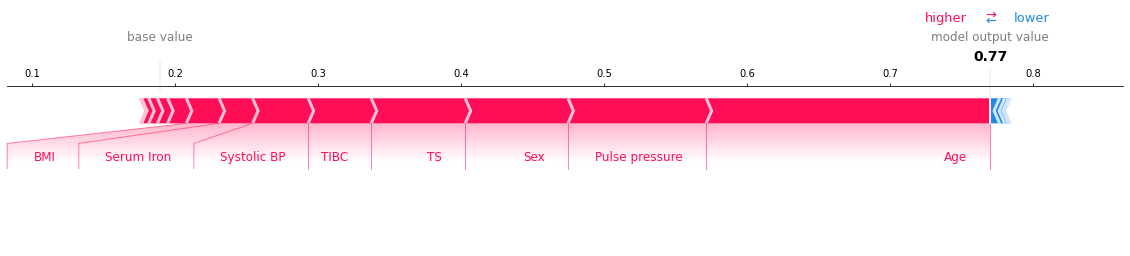

In [ ]:
explainer = shap.TreeExplainer(rf)
i = 0 # Picking an individual
shap_value = explainer.shap_values(X_test.loc[X_test_risky.index[i], :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

For this individual, their age, pulse pressure, and sex were the biggest contributors to their high risk prediction. Note how shapley values gives greater granularity in our interpretations. 

Feel free to change the `i` value above to explore the feature influences for different individuals.

<a name="2-2-2"></a>
#### 2.2.2 Visualizing Feature Importance on Aggregate

Just like with the permutation method, I might also want to understand model output in aggregate. Shapley values allows to do this as well. The next cell initialize the shapley values for each example in the test set. 

In [ ]:
shap_values = shap.TreeExplainer(rf).shap_values(X_test)[1]

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


The next cell shows the summary plot of the shapley values for each feature on each of the test examples. The colors indicate the value of the feature. The features are listed in terms of decreasing absolute average shapley value over all the individuals in the dataset.

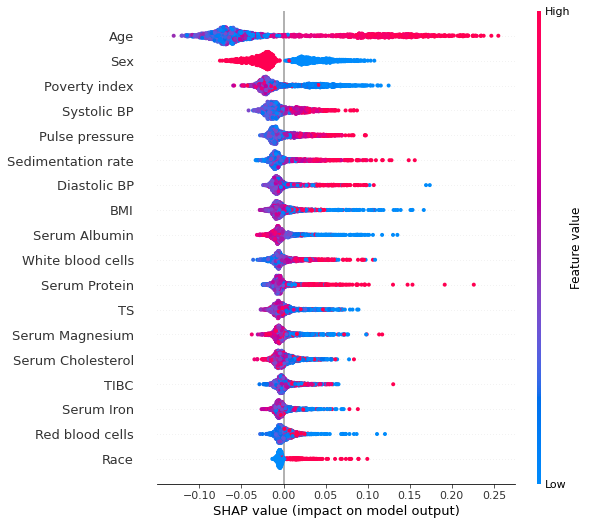

In [ ]:
shap.summary_plot(shap_values, X_test)

The above plot shows a high concentration of points on specific SHAP value ranges. This means that a high proportion of my test set lies on those ranges.

As with the permutation method, age, sex, poverty index, and diastolic BP seem to be the most important features. Being older has a negative impact on mortality, and being a woman (sex=2.0) has a positive effect. 

<a name="2-2-3"></a>
#### 2.2.3 Visualizing Interactions between Features

The `shap` library also lets to visualize interactions between features using dependence plots. These plot the Shapley value for a given feature for each data point, and color the points in using the value for another feature. This lets me begin to explain the variation in shapley value for a single value of the main feature.

The next cell shows the interaction between Age and Sex. 

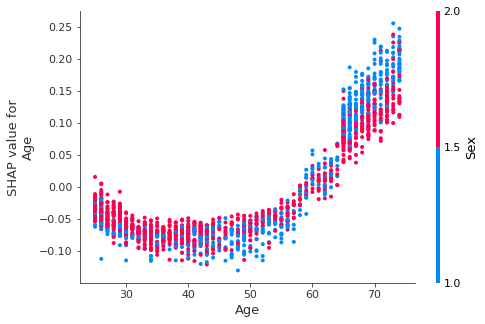

In [ ]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index = 'Sex')

The next cell shows the interaction between Poverty index and Age 

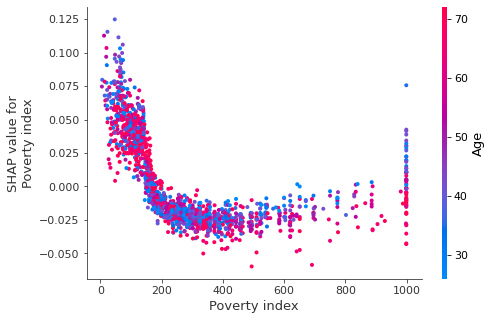

In [ ]:
shap.dependence_plot('Poverty index', shap_values, X_test, interaction_index='Age')